<a href="https://colab.research.google.com/github/DBS-Diego/Certified/blob/main/Pratica_4_KNN_e_Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prática 4 de Aprendizado Supervisionado com KNN e Naive Bayes


* [Playlist de Videos](https://www.youtube.com/playlist?list=PLcvOyD_LMr6n5PaRQ9nYFp--jwFBpjJSc)

## Visualização do KNN

In [ ]:
#@title Exemplo com 3 atributos, você pode ajustar o valor de K e ver os mais próximos em três visualizações 2D
#@title KNN Interativo com make_classification
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
import ipywidgets as widgets
from IPython.display import display, clear_output

# 1. Gerar dados sintéticos
X, y = make_classification(
    n_samples=200,
    n_features=3,
    n_informative=3,
    n_redundant=0,
    n_classes=2,
    random_state=42
)

# 2. Treinar um modelo KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)

# 3. Função para plotar gráficos
def plot_knn(sample_idx=0, k=5):
    clear_output(wait=True)

    # Amostra escolhida
    sample = X[sample_idx].reshape(1, -1)

    # Encontrar vizinhos
    knn_k = KNeighborsClassifier(n_neighbors=k)
    knn_k.fit(X, y)
    neighbors_idx = knn_k.kneighbors(sample, return_distance=False)[0]

    # Predição
    pred = knn_k.predict(sample)[0]

    # Pares de atributos
    pairs = [(0,1), (1,2), (0,2)]
    titles = ["Atributo 1 x 2", "Atributo 2 x 3", "Atributo 1 x 3"]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for ax, (i, j), title in zip(axes, pairs, titles):
        # Pontos normais
        ax.scatter(X[:, i], X[:, j], c=y, cmap="bwr", alpha=0.6, s=30)
        # Vizinhos
        ax.scatter(X[neighbors_idx, i], X[neighbors_idx, j],
                   edgecolor="k", facecolor="none", s=120, linewidths=2, label="Vizinhos")
        # Amostra escolhida
        ax.scatter(sample[0, i], sample[0, j], c="yellow", edgecolor="k", s=200, marker="*", label="Amostra")
        ax.set_xlabel(f"Atr {i+1}")
        ax.set_ylabel(f"Atr {j+1}")
        ax.set_title(title)
        ax.legend()

    plt.suptitle(f"Amostra {sample_idx} | Classe real = {y[sample_idx]} | Classe predita = {pred} (k={k})", fontsize=14)
    plt.show()

# 4. Widgets
sample_slider = widgets.IntSlider(min=0, max=len(X)-1, step=1, value=0, description="Amostra:")
k_slider = widgets.IntSlider(min=1, max=15, step=1, value=5, description="K:")
ui = widgets.VBox([sample_slider, k_slider])

out = widgets.interactive_output(plot_knn, {"sample_idx": sample_slider, "k": k_slider})

display(ui, out)


Output()

### **Questão 1** Por que os vizinhos nem sempre são os mais próximos em todas as visualizações 2D ?

###  **Tarefa 1**  
Alterar o exemplo para fazer com três classes e quatro atributos.

Escreva abaixo quais as linhas de código que foram alteradas



```
# 1. Gerar dados sintéticos
X, y = make_classification(
    n_samples=200,
.....
pairs = [(0,1), (1,2), (0,2), ....
...
```



In [ ]:
# Coloque o código completo aqui


### **Questão 2** Pode acontecer um empate para K=5 e três classes ? Depende das dimensões (número de atributos) ?


## Visualização Parcial da Tabela

In [ ]:
#@title Tente adivinhar a classe com e sem a ajuda do KNN
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean

# Variáveis globais
X = None
y = None
X_train = None
X_test = None
y_train = None
y_test = None
current_test_idx = 0
df = None
output_widget = widgets.Output()
result_widget = widgets.Output()
hint_widget = widgets.Output()

# Criar widgets
n_rows_slider = widgets.IntSlider(
    min=5, max=50, value=10,
    description='Linhas visíveis:',
    style={'description_width': 'initial'}
)

show_table_button = widgets.Button(description='Atualizar Tabela')
new_test_button = widgets.Button(description='Novo Caso de Teste')
hint_button = widgets.Button(description='Mostrar Dicas', button_style='success')

class_buttons = widgets.HBox([
    widgets.Button(description='Classe 0', button_style='info'),
    widgets.Button(description='Classe 1', button_style='warning')
])

# Organizar widgets
controls = widgets.VBox([
    widgets.HBox([n_rows_slider, show_table_button, new_test_button, hint_button]),
    widgets.Label('Faça sua previsão:'),
    class_buttons,
    output_widget,
    hint_widget,
    result_widget
])

def generate_dataset():
    global X, y, X_train, X_test, y_train, y_test, df, current_test_idx

    # Gerar dados
    X, y = make_classification(
        n_samples=1000,
        n_features=5,
        n_classes=2,
        random_state=None
    )

    # Padronizar os dados
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Dividir em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Criar DataFrame
    columns = [f'Atributo_{i+1}' for i in range(5)]
    df_train = pd.DataFrame(X_train, columns=columns)
    df_train['Classe'] = y_train

    df = df_train.copy()
    current_test_idx = 0

    return df

def calculate_distances(test_case, visible_data):
    """Calcula as distâncias euclidianas entre o caso de teste e as amostras visíveis."""
    distances = []
    test_features = test_case.iloc[0, :-1].values  # Excluir coluna 'Classe'

    for idx, row in visible_data.iterrows():
        sample_features = row.iloc[:-1].values  # Excluir coluna 'Classe'
        distance = euclidean(test_features, sample_features)
        distances.append({
            'Índice': idx,
            'Distância': distance,
            'Classe': int(row['Classe'])
        })

    return pd.DataFrame(distances).sort_values('Distância')

def show_table():
    with output_widget:
        clear_output(wait=True)
        n_rows = n_rows_slider.value

        # Mostrar parte da tabela de treino
        print("Dados de Treino:")
        display(df.head(n_rows))

        # Mostrar caso de teste atual
        print("\nCaso para Classificar:")
        test_case = pd.DataFrame([X_test[current_test_idx]],
                               columns=[f'Atributo_{i+1}' for i in range(5)])
        test_case['Classe'] = '?'
        display(test_case)

    # Limpar widgets de dica e resultado
    with hint_widget:
        clear_output(wait=True)
    with result_widget:
        clear_output(wait=True)

def show_hints(b):
    with hint_widget:
        clear_output(wait=True)
        n_rows = n_rows_slider.value

        # Preparar caso de teste
        test_case = pd.DataFrame([X_test[current_test_idx]],
                               columns=[f'Atributo_{i+1}' for i in range(5)])
        test_case['Classe'] = '?'

        # Calcular distâncias para amostras visíveis
        visible_data = df.head(n_rows)
        distances_df = calculate_distances(test_case, visible_data)

        print("Distâncias para as amostras visíveis (ordenadas da mais próxima para a mais distante):")
        print("\nLegenda de cores:")
        print("🔵 Classe 0")
        print("🔴 Classe 1")
        print("\nDistâncias:")

        # Mostrar distâncias com emojis coloridos para as classes
        for _, row in distances_df.iterrows():
            emoji = "🔵" if row['Classe'] == 0 else "🔴"
            print(f"{emoji} Amostra {row['Índice']}: {row['Distância']:.3f}")

        # Análise das K amostras mais próximas
        k_values = [3, 5, 7]
        print("\nAnálise das K amostras mais próximas:")
        for k in k_values:
            k_nearest = distances_df.head(k)
            class_0_count = sum(k_nearest['Classe'] == 0)
            class_1_count = sum(k_nearest['Classe'] == 1)
            print(f"\nK={k}:")
            print(f"🔵 Classe 0: {class_0_count} amostras")
            print(f"🔴 Classe 1: {class_1_count} amostras")

def check_prediction(b):
    with result_widget:
        clear_output(wait=True)
        predicted_class = int(b.description[-1])
        true_class = y_test[current_test_idx]

        if predicted_class == true_class:
            print(f'✅ Correto! A classe verdadeira é {true_class}')
        else:
            print(f'❌ Incorreto. A classe verdadeira é {true_class}')

def new_test_case(b):
    global current_test_idx
    current_test_idx = np.random.randint(len(y_test))
    show_table()

# Configurar callbacks
show_table_button.on_click(lambda b: show_table())
new_test_button.on_click(new_test_case)
hint_button.on_click(show_hints)
for button in class_buttons.children:
    button.on_click(check_prediction)

# Inicializar
generate_dataset()
display(controls)
show_table()

### **Tarefa 2**

Modifique o exemplo para 7 atributos e 3 classes.

## Datasets Sintéticos Maiores

### **TAREFA 3**

Complete a tabela usando o código abaixo

K | Amostras | Classes | Atributos | % teste | Dificuldade | Acuracia | tempo
--|--|--|--|--|--|--|--
3 | 10000 | 2 | 5 | 0.2 | Facil |
3 | 100000 | 2 | 5 | 0.2 | Facil |
3 | 50000 | 5 | 10 | 0.2 | Medio |
3 | 50000 | 5 | 10 | 0.2 | Medio |
5 | 50000 | 10 | 15 | 0.2 | Medio |
10 | 50000 | 10 | 15 | 0.2 | Medio |
10 | 50000 | 20 | 20 | 0.2 | Dificil |
10 | 50000 | 20 | 20 | 0.2 | Dificil |



In [ ]:
#@title Execute com os parametros solicitados para preencher a tabela da **TAREFA 3**
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import time
from IPython.display import clear_output
import ipywidgets as widgets
from IPython.display import display

# Criar widgets
n_samples_slider = widgets.IntSlider(
    value=1000,
    min=1000,
    max=100001,
    step=1000,
    description='Nº Amostras:',
    style={'description_width': 'initial'}
)

n_classes_slider = widgets.IntSlider(
    value=2,
    min=2,
    max=10,
    step=1,
    description='Nº Classes:',
    style={'description_width': 'initial'}
)

n_features_slider = widgets.IntSlider(
    value=2,
    min=2,
    max=20,
    step=1,
    description='Nº Atributos:',
    style={'description_width': 'initial'}
)

test_size_slider = widgets.FloatSlider(
    value=0.2,
    min=0.1,
    max=0.9,
    step=0.1,
    description='% Teste:',
    style={'description_width': 'initial'}
)

difficulty_dropdown = widgets.Dropdown(
    options=[('Fácil', 1), ('Médio', 2), ('Difícil', 3), ('Muito Difícil', 4)],
    value=1,
    description='Dificuldade:',
    style={'description_width': 'initial'}
)

k_neighbors_slider = widgets.IntSlider(
    value=3,
    min=1,
    max=20,
    step=2,
    description='K (KNN):',
    style={'description_width': 'initial'}
)

evaluate_button = widgets.Button(
    description='Avaliar',
    button_style='success'
)

output = widgets.Output()

def create_and_evaluate_model(b):
    with output:
        clear_output()

        # Gerar dataset
        print("Gerando dataset...")
        start_time = time.time()

        X, y = make_classification(
            n_samples=n_samples_slider.value,
            n_classes=n_classes_slider.value,
            n_features=n_features_slider.value,
            n_redundant=0,
            n_informative=n_features_slider.value,
            random_state=1,
            n_clusters_per_class=1,
            class_sep=1.0/difficulty_dropdown.value  # Ajusta a separação das classes baseado na dificuldade
        )

        # Dividir dataset
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size=test_size_slider.value,
            random_state=42
        )

        # Treinar modelo KNN
        print("Treinando modelo KNN...")
        knn = KNeighborsClassifier(n_neighbors=k_neighbors_slider.value)
        knn.fit(X_train, y_train)

        # Fazer predições
        y_pred = knn.predict(X_test)

        # Calcular acurácia
        accuracy = accuracy_score(y_test, y_pred)

        # Calcular tempo total
        total_time = time.time() - start_time

        # Mostrar resultados
        print("\nResultados:")
        print(f"Acurácia: {accuracy:.4f}")
        print(f"Tempo de execução: {total_time:.2f} segundos")
        print(f"\nParâmetros utilizados:")
        print(f"Número de amostras: {n_samples_slider.value}")
        print(f"Número de classes: {n_classes_slider.value}")
        print(f"Número de atributos: {n_features_slider.value}")
        print(f"Porcentagem de teste: {test_size_slider.value*100}%")
        print(f"Nível de dificuldade: {difficulty_dropdown.label}")
        print(f"Valor de K: {k_neighbors_slider.value}")

# Conectar botão à função
evaluate_button.on_click(create_and_evaluate_model)

# Layout dos widgets
box_layout = widgets.Layout(display='flex',
                          flex_flow='column',
                          align_items='stretch',
                          width='50%')

vbox = widgets.VBox([
    n_samples_slider,
    n_classes_slider,
    n_features_slider,
    test_size_slider,
    difficulty_dropdown,
    k_neighbors_slider,
    evaluate_button,
    output
], layout=box_layout)

display(vbox)

## Dataset de Culturas  **TAREFA 4**
 Para os dados do dataset predicao_cultura.csv, fazer uma exploracao de dados: numeros de amostras, atributos numéricos e categóricos, gráficos da coluna target em % por classe, boxplot e histograma dos dados numéricos e gráfico de barras dos dados categóricos.

In [ ]:
#colab
!wget -q https://raw.githubusercontent.com/AdilsonRLopes/datasets/main/predicao_cultura.csv

In [ ]:
#harp
df = pd.read_csv("/home/inf121/pratica/predicao_cultura.csv")

In [ ]:
#@title Exploração dos Dados - faça seu código aqui...


In [ ]:
#@title KNN do Culturas supondo que a planilha foi lida para o dataframe Pandas df
# -----------------------------
# Classificação e métricas1
# -----------------------------
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import time

# Separar features e target
X = df[num_cols]  # usando apenas colunas numéricas
y = df['target']

# Codificar target se necessário
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Normalizar features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# Definir classificador KNN (pode ajustar n_neighbors)
modelo = KNeighborsClassifier(n_neighbors=5)

# Medir tempo
start_time = time.time()

# Treinar
modelo.fit(X_train, y_train)

# Previsões
y_pred = modelo.predict(X_test)

end_time = time.time()
elapsed_time = end_time - start_time

# Acurácia
acc = accuracy_score(y_test, y_pred)
print(f"\nAcurácia: {acc:.4f}")

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
print("\nMatriz de Confusão:")
print(cm)

# Tempo de execução
print(f"\nTempo de execução (s): {elapsed_time:.4f}")



Acurácia: 0.9952

Matriz de Confusão:
[[30  0  0  0  0  0  0]
 [ 0 30  0  0  0  0  0]
 [ 0  0 30  0  0  0  0]
 [ 0  0  0 30  0  0  0]
 [ 0  0  0  0 30  0  0]
 [ 0  0  1  0  0 29  0]
 [ 0  0  0  0  0  0 30]]

Tempo de execução (s): 0.0065


### **Questão** O KNN tem uma acurácia bem alta com o dataset de culturas. Experimente reduzir a porcentagem de treino que está em 70% para a 50%, 30% e 10%. Lembre-se que especificamos a parte de teste, então 0.3 de teste significa 70% treino e 30% teste. No caso do KNN, se selecionamos 70% para testes, ele irá buscar estes 70% para classificar olhando apenas 30% do treino.

## Dataset do Arroz, Feijão e Vinho

* Executar a célula Colab se estiver no Colab
* Ou executar a célula Harp

In [ ]:
# Colab
!wget "https://raw.githubusercontent.com/Knovsa11/Rice-Type-Classification/refs/heads/main/riceClassification.csv"
!wget "https://raw.githubusercontent.com/arduinoufv/inf121/refs/heads/main/datasets/drybean.csv"
!wget "https://raw.githubusercontent.com/arduinoufv/inf121/refs/heads/main/datasets/wine.csv"
import pandas as pd
# Ler CSV
df = pd.read_csv("riceClassification.csv")

--2025-09-01 23:59:02--  https://raw.githubusercontent.com/Knovsa11/Rice-Type-Classification/refs/heads/main/riceClassification.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2027644 (1.9M) [text/plain]
Saving to: ‘riceClassification.csv.2’

riceClassification. 100%[===================>]   1.93M  --.-KB/s    in 0.05s   

2025-09-01 23:59:02 (42.9 MB/s) - ‘riceClassification.csv.2’ saved [2027644/2027644]

--2025-09-01 23:59:02--  https://raw.githubusercontent.com/arduinoufv/inf121/refs/heads/main/datasets/drybean.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request se

### Harp usar



```
# arroz
df = pd.read_csv("/home/inf121/pratica/riceClassification.csv")
```

```
# feijao
df = pd.read_csv("/home/inf121/pratica/drybean.csv")
```



```
# vinho
df = pd.read_csv("/home/inf121/pratica/wine.csv")
```


### **TAREFA 5**

similar ao exemplo da predição de culturas para o Arroz, Feijão e Vinho

* Fazer a exploração de dados sabendo que a variável alvo é "Class" para o arroz e feijao. Para o Vinho você terá que criar a variável alvo.
     * Use a coluna "Proline" pela faixas três faixas de 200-500 (baixo), 500-800 (medio), acima 800 (alto).
* Fazer o Knn para os três exemplos. Complete a tabela

Dataset | K | Acurácia | Tempo Execução
--|--|--|--
Arroz | 3 |
Arroz | 10 |
Feijao | 3 |
Feijao | 10 |
Vinho | 3 |
Vinho | 10 |

In [ ]:
#@title Exploração do Arroz

In [ ]:
#@title Knn do Arroz

In [ ]:
#@title Exploração do Feijão

In [ ]:
#@title KNN do Feijão

In [ ]:
#@title para Preparar o Wine para CLass
import pandas as pd

# Ler o dataset
df = pd.read_csv("wine.csv")
#harp
#df = pd.read_csv("/home/inf121/pratica/wine.csv")

# Criar a nova coluna "Class" a partir de "Proline"
df["Class"] = pd.cut(
    df["Proline"],
    bins=[-float("inf"), 500, 800, float("inf")],
    labels=["Baixo", "Medio", "Alto"]
)

# Remover a coluna Proline
df = df.drop(columns=["Proline"])

# Visualizar as primeiras linhas
print(df.head())


   Wine  Alcohol  Malic.acid   Ash   Acl   Mg  Phenols  Flavanoids  \
0     1    14.23        1.71  2.43  15.6  127     2.80        3.06   
1     1    13.20        1.78  2.14  11.2  100     2.65        2.76   
2     1    13.16        2.36  2.67  18.6  101     2.80        3.24   
3     1    14.37        1.95  2.50  16.8  113     3.85        3.49   
4     1    13.24        2.59  2.87  21.0  118     2.80        2.69   

   Nonflavanoid.phenols  Proanth  Color.int   Hue    OD  Class  
0                  0.28     2.29       5.64  1.04  3.92   Alto  
1                  0.26     1.28       4.38  1.05  3.40   Alto  
2                  0.30     2.81       5.68  1.03  3.17   Alto  
3                  0.24     2.18       7.80  0.86  3.45   Alto  
4                  0.39     1.82       4.32  1.04  2.93  Medio  


In [ ]:
#@title Exploração do Vinho

In [ ]:
#@title KNN para Vinho

### Seleção de Atributos

**TAREFA 6**

Se usarmos apenas alguns atributos para o Arroz. Usar o código abaixo para descobrir uma seleção de apenas 3 atributos que resulte:
* Melhor acurácia:
  1.
  2.
  3.
* Pior Acurácia:
  1.
  2.
  3.   



In [ ]:
#@title KNN interativo com seleção de atributos + boxplots separados por feature
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import ipywidgets as widgets
from IPython.display import display, clear_output

# Carregar dataset
df = pd.read_csv("riceClassification.csv")
# Harp
#df = pd.read_csv("/home/inf121/pratica/riceClassification.csv")

# Identificar colunas
features = df.drop(columns=["Class"]).columns.tolist()
target = "Class"

# Widgets
checklist = widgets.SelectMultiple(
    options=features,
    value=[features[0], features[1]], # começa com 2 selecionados
    description="Atributos",
    disabled=False
)

k_slider = widgets.IntSlider(
    value=3,
    min=1,
    max=15,
    step=1,
    description='K:',
    continuous_update=False
)

submit_btn = widgets.Button(
    description="Submeter",
    button_style="success"
)

out = widgets.Output()

def on_submit(b):
    with out:
        clear_output()

        selected_features = list(checklist.value)
        if len(selected_features) == 0:
            print("⚠️ Selecione ao menos um atributo!")
            return

        X = df[selected_features]
        y = df[target]

        # Treino/teste
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42
        )

        # Modelo KNN
        knn = KNeighborsClassifier(n_neighbors=k_slider.value)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)

        # Métricas
        acc = accuracy_score(y_test, y_pred)
        print(f"✅ Acurácia: {acc:.4f}")

        # Matriz de confusão
        cm = confusion_matrix(y_test, y_pred, labels=knn.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
        disp.plot(cmap=plt.cm.Blues)
        plt.show()

        # Boxplots separados por feature
        for feature in selected_features:
            plt.figure(figsize=(6, 4))
            sns.boxplot(data=df, x="Class", y=feature)
            plt.title(f"📊 Boxplot de {feature} por Classe")
            plt.xlabel("Classe")
            plt.ylabel(feature)
            plt.show()

submit_btn.on_click(on_submit)

# Layout
display(widgets.VBox([checklist, k_slider, submit_btn, out]))


In [ ]:
#@title KNN interativo com seleção de atributos + opção de normalização
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import ipywidgets as widgets
from IPython.display import display, clear_output

# Carregar dataset
df = pd.read_csv("riceClassification.csv")
# harp
# df = pd.read_csv("/home/inf121/pratica/riceClassification.csv")
# Identificar colunas
features = df.drop(columns=["Class"]).columns.tolist()
target = "Class"

# Widgets
checklist = widgets.SelectMultiple(
    options=features,
    value=[features[0], features[1]], # começa com 2 selecionados
    description="Atributos",
    disabled=False
)

k_slider = widgets.IntSlider(
    value=3,
    min=1,
    max=15,
    step=1,
    description='K:',
    continuous_update=False
)

normalize_checkbox = widgets.Checkbox(
    value=True,
    description="Normalizar dados",
    disabled=False
)

submit_btn = widgets.Button(
    description="Submeter",
    button_style="success"
)

out = widgets.Output()

def on_submit(b):
    with out:
        clear_output()

        selected_features = list(checklist.value)
        if len(selected_features) == 0:
            print("⚠️ Selecione ao menos um atributo!")
            return

        X = df[selected_features]
        y = df[target]

        # Treino/teste
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42
        )

        # Normalização opcional
        if normalize_checkbox.value:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

        # Modelo KNN
        knn = KNeighborsClassifier(n_neighbors=k_slider.value)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)

        # Métricas
        acc = accuracy_score(y_test, y_pred)
        print(f"✅ Acurácia: {acc:.4f}")
        print("🔹 Normalização:", "Ativada" if normalize_checkbox.value else "Desativada")

        # Matriz de confusão
        cm = confusion_matrix(y_test, y_pred, labels=knn.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
        disp.plot(cmap=plt.cm.Blues)
        plt.show()

        # Boxplots separados por feature
        for feature in selected_features:
            plt.figure(figsize=(6, 4))
            sns.boxplot(data=df, x="Class", y=feature)
            plt.title(f"📊 Boxplot de {feature} por Classe")
            plt.xlabel("Classe")
            plt.ylabel(feature)
            plt.show()

submit_btn.on_click(on_submit)

# Layout
display(widgets.VBox([checklist, k_slider, normalize_checkbox, submit_btn, out]))


# Regressão

**TAREFA 7** Use os mesmos dados do riceClassification para fazer uma regressão com KNN e mostrar o perimeter:
* MAE
* MSE
* R2
* Grafico do valor predito e do real.
* Visualizar o erro para uma amostra escolhida com um slider.

In [ ]:
#@title KNN para regressão com perimeter para Arroz

# Naive Bayes



* Para o dataset de culturas podemos fazer a visualização da distribuição das probabilidades por classe e por atributo
* Executando o Naive Bayes e verifique se a acurácia é muito alta  devido ao dataset.


Acurácia do Naive Bayes: 100.00%


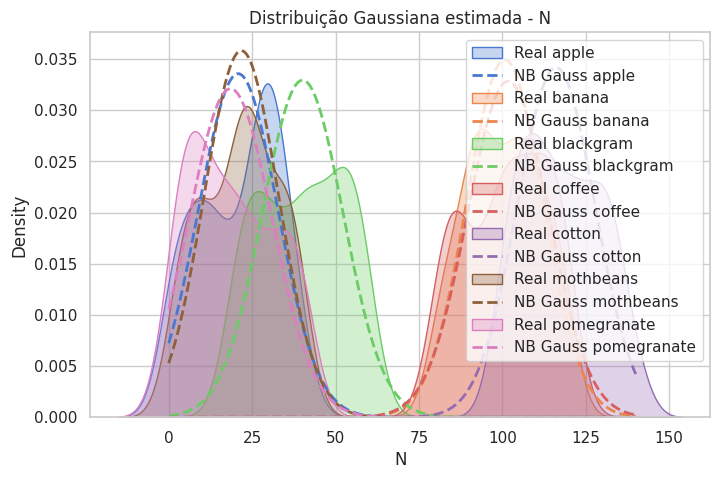

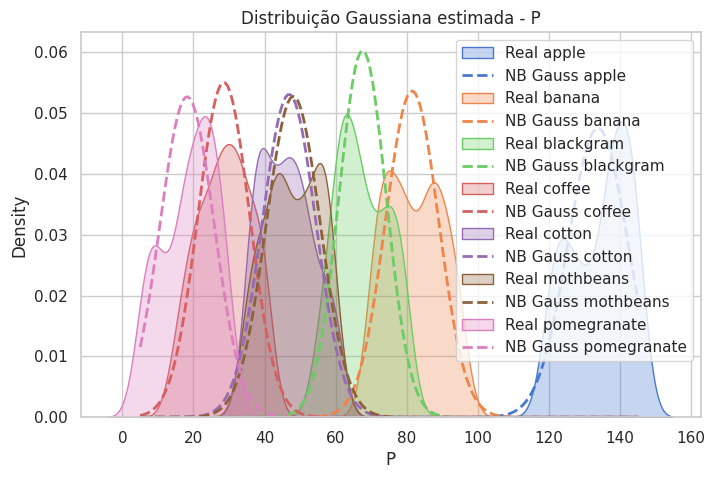

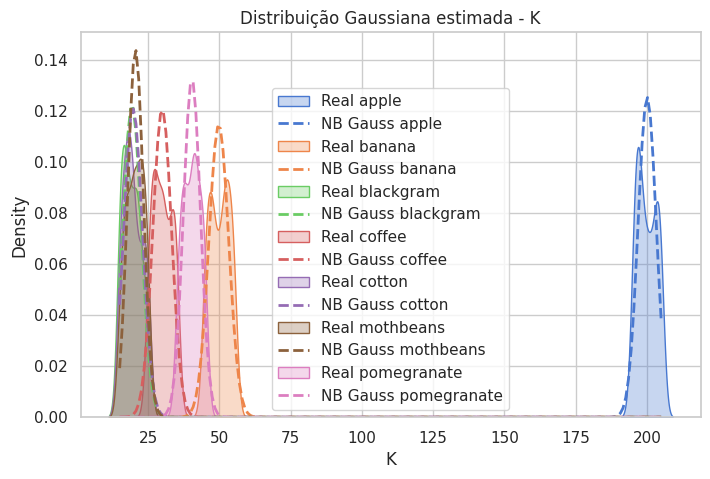

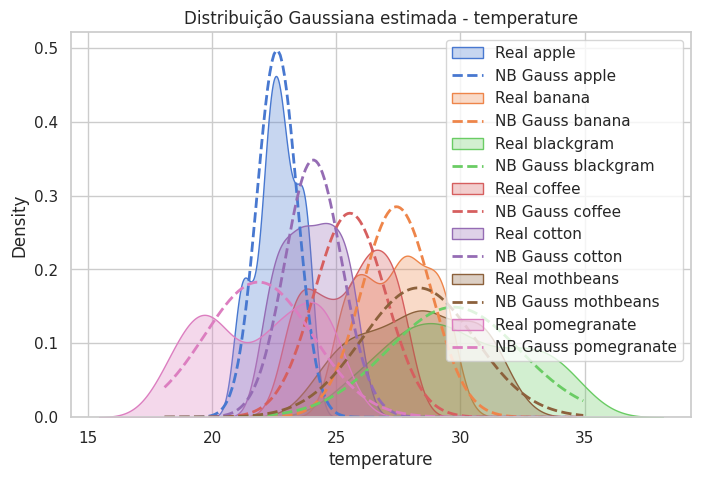

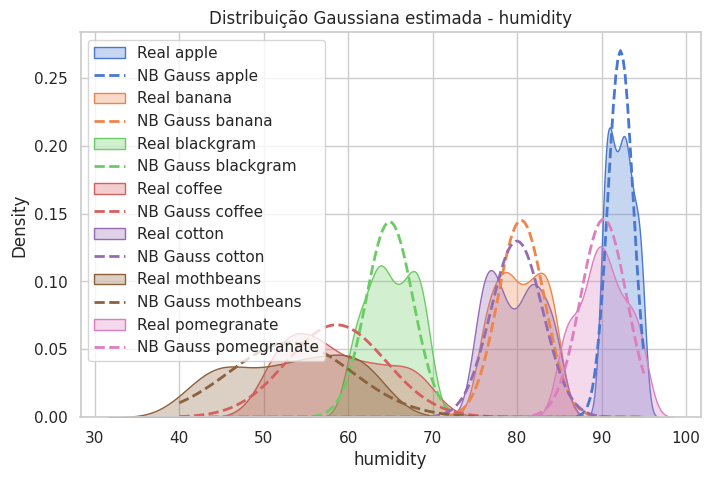

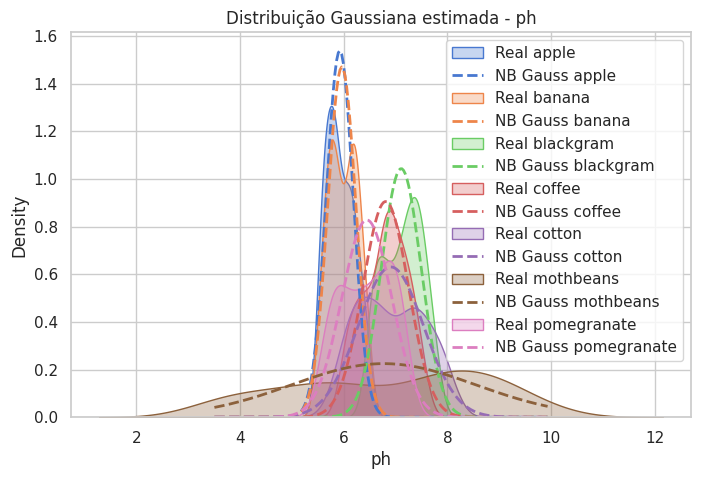

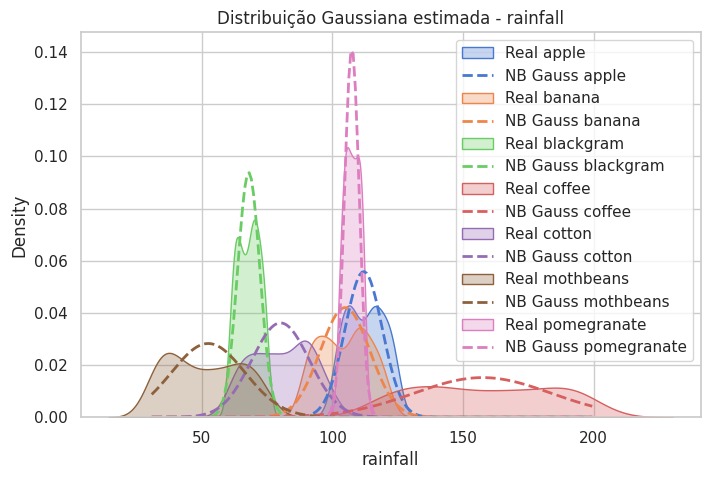

In [ ]:
#@title Naive Bayes - Predição de Cultura com Distribuições Gaussianas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

sns.set(style="whitegrid", palette="muted", color_codes=True)

df = pd.read_csv("predicao_cultura.csv")
# harp
#df = pd.read_csv("/home/inf121/pratica/predicao_cultura.csv")

num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
target = "target"

X = df[num_cols]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Acurácia do Naive Bayes: {acc:.2%}")

classes = nb.classes_

for col_idx, col in enumerate(num_cols):
    plt.figure(figsize=(8,5))

    for c in classes:
        subset = df[df[target] == c][col]
        sns.kdeplot(subset, label=f"Real {c}", fill=True, alpha=0.3)

        # Distribuição gaussiana estimada pelo NB
        mean = nb.theta_[classes.tolist().index(c), col_idx]
        var = nb.var_[classes.tolist().index(c), col_idx]  # <-- mudou sigma_ -> var_
        std = np.sqrt(var)

        x = np.linspace(df[col].min(), df[col].max(), 200)
        pdf = (1/(std*np.sqrt(2*np.pi))) * np.exp(-0.5*((x-mean)/std)**2)

        plt.plot(x, pdf, linestyle="--", linewidth=2, label=f"NB Gauss {c}")

    plt.title(f"Distribuição Gaussiana estimada - {col}")
    plt.legend()
    plt.show()


**Tarefa 8**

* Fazer o Naive Bayes para o dataset do Arroz, Feijao e do Vinho com a visualização dos features com a distribuição, semelhante ao exemplo das culturas.

* Complete a Tabela

Dataset | Acuracia
--|--
Arroz |
Feijao |
Vinho |
